In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

### Data preparation, Data partitioning and normalization

In [2]:
class_name = 'Occupancy'
df1 = pd.read_csv('datatraining.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df2 =pd.read_csv('datatest.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df3=pd.read_csv('datatest2.txt', skipinitialspace=True, na_values='?', 
                 keep_default_na=True)
df4=pd.merge(df1, df2, how='outer')
df=pd.merge(df4, df3, how='outer')

In [3]:
df['Day']=pd.to_datetime(df['date']).dt.day
df['Hour']=pd.to_datetime(df['date']).dt.hour
df['Month']=pd.to_datetime(df['date']).dt.month
df['Year']=pd.to_datetime(df['date']).dt.year
df['Data']=pd.to_datetime(df['date']).dt.normalize()
del df['date']

In [4]:
df['Day']=df['Data'].dt.dayofweek
df.drop(['Year','Month','Data'], axis='columns', inplace=True)
del df['HumidityRatio']

In [5]:
from data_preparation import prepare_dataset

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,Day,Hour,Occupancy
0,23.18,27.2720,426.0,721.25,2,17,1
1,23.15,27.2675,429.5,714.00,2,17,1
2,23.15,27.2450,426.0,713.50,2,17,1
3,23.15,27.2000,426.0,708.25,2,17,1
4,23.10,27.2000,426.0,704.50,2,17,1


In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Single layer network

In [11]:
from sklearn.linear_model import Perceptron

In [12]:
sln=Perceptron()

In [13]:
sln.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
y_pred_sln = sln.predict(X_test)

In [15]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_sln))
print('F1-score %s' % f1_score(y_test, y_pred_sln, average=None))
print(classification_report(y_test, y_pred_sln))

Accuracy 0.9854085603112841
F1-score [0.99049028 0.96866295]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4743
           1       0.96      0.98      0.97      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.98      0.98      6168
weighted avg       0.99      0.99      0.99      6168



non posso fare roc curve ne lift chart perchè questo classificatore non ha clf.proba (Perceptrons do not output a class probability; rather,
they just make predictions based on a hard threshold. This is one of the good reasons to prefer Logistic
Regression over Perceptrons.)


## Multiple layer network

In [16]:
from sklearn.neural_network import MLPClassifier

In [17]:
mln = MLPClassifier(random_state=0)

mln.fit(X_train, y_train)

y_pred_mln = mln.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_mln))
print('F1-score %s' % f1_score(y_test, y_pred_mln, average=None))
print(classification_report(y_test, y_pred_mln))

Accuracy 0.9920557717250325
F1-score [0.99481317 0.98303911]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4743
           1       0.97      1.00      0.98      1425

    accuracy                           0.99      6168
   macro avg       0.98      0.99      0.99      6168
weighted avg       0.99      0.99      0.99      6168



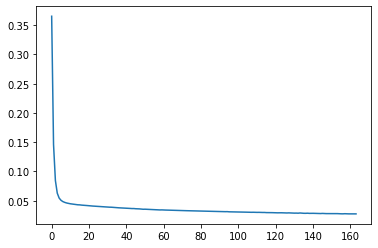

In [18]:
plt.plot(mln.loss_curve_)
plt.show()

non sembrano esserci problemi ne di overfitting ne di underfitting:
    - overfitting: The plot of training loss continues to decrease with experience or The plot of validation loss decreases to a point and begins increasing again.
    - underfitting:The training loss remains flat regardless of training or The training loss continues to decrease until the end of training.

This example visualizes some training loss curves for different stochastic learning strategies, including SGD and Adam. 

In [19]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

In [20]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate
training set score and loss: 0.769, 5.606281


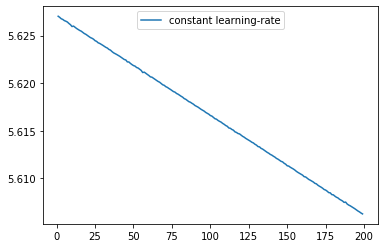

constant with momentum
training set score and loss: 0.769, 488.868846


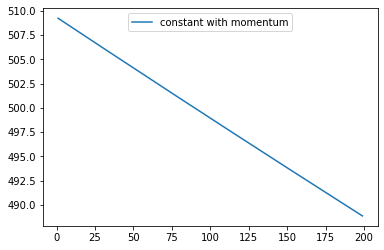

constant with Nesterov's momentum
training set score and loss: 0.769, 1603.213153


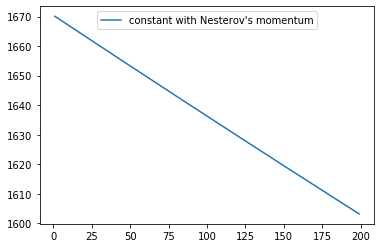

inv-scaling learning-rate
training set score and loss: 0.769, 5.627009


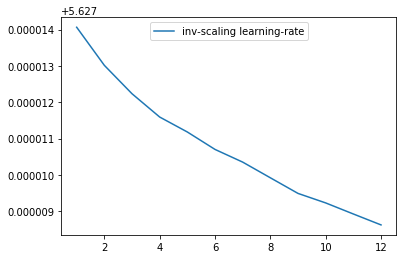

inv-scaling with momentum
training set score and loss: 0.769, 1670.178766


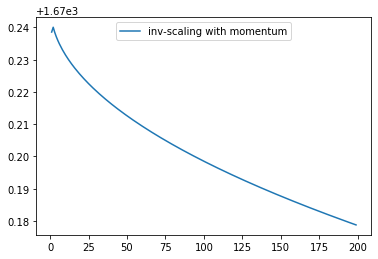

inv-scaling with Nesterov's momentum
training set score and loss: 0.769, 509.280629


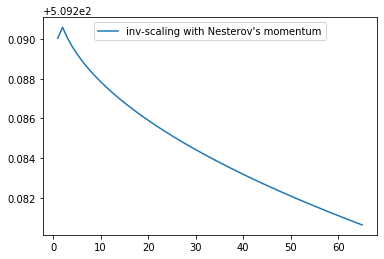

adam
training set score and loss: 0.990, 0.051007


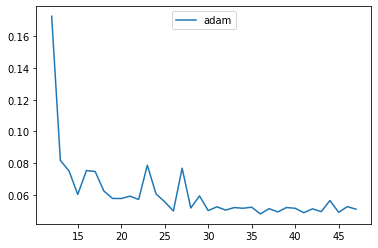

In [21]:
for label, param in zip(labels, params):
    print(label)
    mlp = MLPClassifier(random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp.fit(X, y)

    print("training set score and loss: %.3f, %f" % (mlp.score(X, y), mlp.loss_))
    plt.plot(mlp.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

tutte le strategie portano ad overfitting: le prime sei perche la loss curve continuano a decrescere con l'esperienza, mentre l'ultima strategia decresce da un punto e riprendere a crescere da un altro punto

## keras DNN

In [16]:
from keras.models import Sequential
from keras.layers import Dense

In [25]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(128, input_dim=n_feature, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

-The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.(The batch size is a number of samples processed before the model is updated)


-The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.(The number of epochs is the number of complete passes through the training dataset)

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

In [38]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Epoch 1/50
14392/14392 [==============================] - 2s 160us/step - loss: 0.0565 - accuracy: 0.9869
Epoch 2/50
14392/14392 [==============================] - 2s 157us/step - loss: 0.0406 - accuracy: 0.9893
Epoch 3/50
14392/14392 [==============================] - 2s 162us/step - loss: 0.0379 - accuracy: 0.9890
Epoch 4/50
14392/14392 [==============================] - 2s 147us/step - loss: 0.0354 - accuracy: 0.9891
Epoch 5/50
14392/14392 [==============================] - 2s 154us/step - loss: 0.0336 - accuracy: 0.9892
Epoch 6/50
14392/14392 [==============================] - 2s 144us/step - loss: 0.0321 - accuracy: 0.9897
Epoch 7/50
14392/14392 [==============================] - 2s 142us/step - loss: 0.0314 - accuracy: 0.9896
Epoch 8/50
14392/14392 [==============================] - 2s 150us/step - loss: 0.0310 - accuracy: 0.9902
Epoch 9/50
14392/14392 [==============================] - 2s 143us/step - loss: 0.0298 - accuracy: 0.9910
Epoch 10/50
14392/14392 [=====================

In [34]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
14392/14392 [==============================] - 1s 48us/step - loss: 0.1116 - accuracy: 0.9657
Epoch 2/50
14392/14392 [==============================] - 0s 33us/step - loss: 0.0432 - accuracy: 0.9893
Epoch 3/50
14392/14392 [==============================] - 0s 34us/step - loss: 0.0406 - accuracy: 0.9892
Epoch 4/50
14392/14392 [==============================] - 0s 33us/step - loss: 0.0393 - accuracy: 0.9894
Epoch 5/50
14392/14392 [==============================] - 0s 34us/step - loss: 0.0375 - accuracy: 0.9893 0s - loss: 0.0273 
Epoch 6/50
14392/14392 [==============================] - 0s 33us/step - loss: 0.0360 - accuracy: 0.9897
Epoch 7/50
14392/14392 [==============================] - 0s 33us/step - loss: 0.0358 - accuracy: 0.9894
Epoch 8/50
14392/14392 [==============================] - 0s 33us/step - loss: 0.0342 - accuracy: 0.9893
Epoch 9/50
14392/14392 [==============================] - 0s 33us/step - loss: 0.0330 - accuracy: 0.9896
Epoch 10/50
14392/14392 [===========

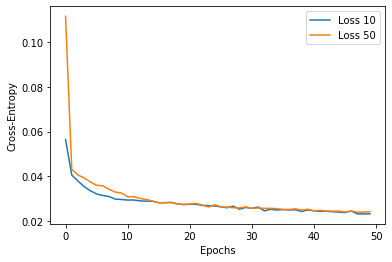

In [39]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [40]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

6168/6168 [==============================] - 0s 25us/step
Loss 0.029139, Accuracy 0.991894
Loss 0.029003, Accuracy 0.992704


In [42]:
y_pred = model2.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7691309987029832
F1-score [0.86947754 0.00140252]
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      4743
           1       1.00      0.00      0.00      1425

    accuracy                           0.77      6168
   macro avg       0.88      0.50      0.44      6168
weighted avg       0.82      0.77      0.67      6168



In [46]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=50).history

Train on 14392 samples, validate on 6168 samples
Epoch 1/500
14392/14392 [==============================] - 1s 89us/step - loss: 0.1051 - accuracy: 0.9724 - val_loss: 0.0385 - val_accuracy: 0.9916
Epoch 2/500
14392/14392 [==============================] - 1s 79us/step - loss: 0.0428 - accuracy: 0.9894 - val_loss: 0.0352 - val_accuracy: 0.9914
Epoch 3/500
14392/14392 [==============================] - 1s 78us/step - loss: 0.0405 - accuracy: 0.9892 - val_loss: 0.0340 - val_accuracy: 0.9914
Epoch 4/500
14392/14392 [==============================] - 1s 69us/step - loss: 0.0387 - accuracy: 0.9894 - val_loss: 0.0340 - val_accuracy: 0.9916
Epoch 5/500
14392/14392 [==============================] - 1s 70us/step - loss: 0.0375 - accuracy: 0.9896 - val_loss: 0.0328 - val_accuracy: 0.9916
Epoch 6/500
14392/14392 [==============================] - 1s 61us/step - loss: 0.0366 - accuracy: 0.9892 - val_loss: 0.0373 - val_accuracy: 0.9899
Epoch 7/500
14392/14392 [==============================] - 1s 6

Epoch 56/500
14392/14392 [==============================] - 1s 99us/step - loss: 0.0240 - accuracy: 0.9916 - val_loss: 0.0282 - val_accuracy: 0.9922
Epoch 57/500
14392/14392 [==============================] - 1s 76us/step - loss: 0.0242 - accuracy: 0.9917 - val_loss: 0.0286 - val_accuracy: 0.9919
Epoch 58/500
14392/14392 [==============================] - 1s 65us/step - loss: 0.0236 - accuracy: 0.9912 - val_loss: 0.0280 - val_accuracy: 0.9922
Epoch 59/500
14392/14392 [==============================] - 1s 76us/step - loss: 0.0235 - accuracy: 0.9916 - val_loss: 0.0292 - val_accuracy: 0.9908
Epoch 60/500
14392/14392 [==============================] - 1s 78us/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.0276 - val_accuracy: 0.9921
Epoch 61/500
14392/14392 [==============================] - 1s 87us/step - loss: 0.0234 - accuracy: 0.9915 - val_loss: 0.0288 - val_accuracy: 0.9924
Epoch 62/500
14392/14392 [==============================] - 1s 82us/step - loss: 0.0239 - accuracy: 0.9919

Epoch 111/500
14392/14392 [==============================] - 1s 82us/step - loss: 0.0210 - accuracy: 0.9927 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 112/500
14392/14392 [==============================] - 1s 79us/step - loss: 0.0213 - accuracy: 0.9917 - val_loss: 0.0282 - val_accuracy: 0.9919
Epoch 113/500
14392/14392 [==============================] - 1s 78us/step - loss: 0.0215 - accuracy: 0.9928 - val_loss: 0.0314 - val_accuracy: 0.9904
Epoch 114/500
14392/14392 [==============================] - 1s 82us/step - loss: 0.0212 - accuracy: 0.9918 - val_loss: 0.0298 - val_accuracy: 0.9921
Epoch 115/500
14392/14392 [==============================] - 1s 77us/step - loss: 0.0214 - accuracy: 0.9921 - val_loss: 0.0288 - val_accuracy: 0.9927
Epoch 116/500
14392/14392 [==============================] - 1s 68us/step - loss: 0.0213 - accuracy: 0.9924 - val_loss: 0.0318 - val_accuracy: 0.9904
Epoch 117/500
14392/14392 [==============================] - 1s 59us/step - loss: 0.0217 - accuracy:

Epoch 220/500
14392/14392 [==============================] - 1s 78us/step - loss: 0.0181 - accuracy: 0.9930 - val_loss: 0.0347 - val_accuracy: 0.9898
Epoch 221/500
14392/14392 [==============================] - 1s 74us/step - loss: 0.0186 - accuracy: 0.9930 - val_loss: 0.0344 - val_accuracy: 0.9917
Epoch 222/500
14392/14392 [==============================] - 1s 76us/step - loss: 0.0185 - accuracy: 0.9924 - val_loss: 0.0346 - val_accuracy: 0.9912
Epoch 223/500
14392/14392 [==============================] - 1s 76us/step - loss: 0.0183 - accuracy: 0.9929 - val_loss: 0.0343 - val_accuracy: 0.9909
Epoch 224/500
14392/14392 [==============================] - 1s 67us/step - loss: 0.0185 - accuracy: 0.9928 - val_loss: 0.0346 - val_accuracy: 0.9912
Epoch 225/500
14392/14392 [==============================] - 1s 70us/step - loss: 0.0183 - accuracy: 0.9931 - val_loss: 0.0378 - val_accuracy: 0.9887
Epoch 226/500
14392/14392 [==============================] - 1s 73us/step - loss: 0.0177 - accuracy:

Epoch 329/500
14392/14392 [==============================] - 1s 65us/step - loss: 0.0163 - accuracy: 0.9936 - val_loss: 0.0396 - val_accuracy: 0.9901
Epoch 330/500
14392/14392 [==============================] - 1s 66us/step - loss: 0.0169 - accuracy: 0.9933 - val_loss: 0.0384 - val_accuracy: 0.9911
Epoch 331/500
14392/14392 [==============================] - 1s 65us/step - loss: 0.0166 - accuracy: 0.9931 - val_loss: 0.0402 - val_accuracy: 0.9914
Epoch 332/500
14392/14392 [==============================] - 1s 85us/step - loss: 0.0164 - accuracy: 0.9934 - val_loss: 0.0425 - val_accuracy: 0.9921
Epoch 333/500
14392/14392 [==============================] - 1s 75us/step - loss: 0.0158 - accuracy: 0.9939 - val_loss: 0.0401 - val_accuracy: 0.9914
Epoch 334/500
14392/14392 [==============================] - 1s 70us/step - loss: 0.0164 - accuracy: 0.9934 - val_loss: 0.0404 - val_accuracy: 0.9890
Epoch 335/500
14392/14392 [==============================] - 1s 64us/step - loss: 0.0162 - accuracy:

Epoch 438/500
14392/14392 [==============================] - 1s 59us/step - loss: 0.0147 - accuracy: 0.9941 - val_loss: 0.0441 - val_accuracy: 0.9904
Epoch 439/500
14392/14392 [==============================] - 1s 67us/step - loss: 0.0154 - accuracy: 0.9930 - val_loss: 0.0431 - val_accuracy: 0.9895
Epoch 440/500
14392/14392 [==============================] - 1s 72us/step - loss: 0.0152 - accuracy: 0.9939 - val_loss: 0.0427 - val_accuracy: 0.9914
Epoch 441/500
14392/14392 [==============================] - 1s 69us/step - loss: 0.0151 - accuracy: 0.9937 - val_loss: 0.0425 - val_accuracy: 0.9896
Epoch 442/500
14392/14392 [==============================] - 1s 69us/step - loss: 0.0151 - accuracy: 0.9937 - val_loss: 0.0401 - val_accuracy: 0.9924
Epoch 443/500
14392/14392 [==============================] - 1s 71us/step - loss: 0.0148 - accuracy: 0.9938 - val_loss: 0.0407 - val_accuracy: 0.9912
Epoch 444/500
14392/14392 [==============================] - 1s 68us/step - loss: 0.0149 - accuracy:

In [47]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

6168/6168 [==============================] - 0s 39us/step
Loss 0.029139, Accuracy 0.991894
Loss 0.029003, Accuracy 0.992704
Loss 0.049051, Accuracy 0.991732


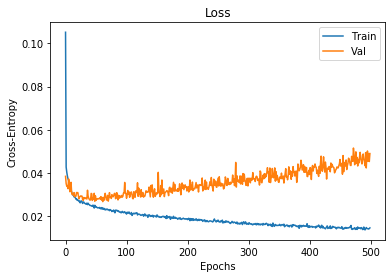

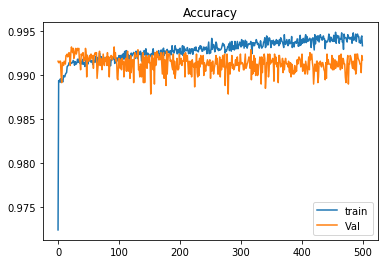

In [64]:
#plot loss during training
plt.title('Loss')
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

# plot accuracy during training

plt.title('Accuracy')
plt.plot(history3['accuracy'], label='train')
plt.plot(history3['val_accuracy'], label='Val')
plt.legend()
plt.show()

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Early stopping

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [51]:
es = EarlyStopping(monitor='val_loss', patience=10)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                      batch_size=10, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/100
11513/11513 [==============================] - 4s 336us/step - loss: 0.0626 - accuracy: 0.9852 - val_loss: 0.0324 - val_accuracy: 0.9927
Epoch 2/100
11513/11513 [==============================] - 4s 339us/step - loss: 0.0432 - accuracy: 0.9881 - val_loss: 0.0291 - val_accuracy: 0.9927
Epoch 3/100
11513/11513 [==============================] - 4s 321us/step - loss: 0.0407 - accuracy: 0.9886 - val_loss: 0.0301 - val_accuracy: 0.9927
Epoch 4/100
11513/11513 [==============================] - 4s 308us/step - loss: 0.0388 - accuracy: 0.9884 - val_loss: 0.0278 - val_accuracy: 0.9927
Epoch 5/100
11513/11513 [==============================] - 3s 284us/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0271 - val_accuracy: 0.9934
Epoch 6/100
11513/11513 [==============================] - 4s 311us/step - loss: 0.0343 - accuracy: 0.9890 - val_loss: 0.0291 - val_accuracy: 0.9927
Epoch 7/100
11513/11513 [==============================] 

In [52]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

6168/6168 [==============================] - 0s 35us/step
Loss 0.029139, Accuracy 0.991894
Loss 0.029003, Accuracy 0.992704
Loss 0.049051, Accuracy 0.991732
Loss 0.028266, Accuracy 0.992218


In [ ]:
#plot loss during training
plt.title('Loss')
plt.plot(history4['loss'], label='Train')
plt.plot(history4['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

# plot accuracy during training

plt.title('Accuracy')
plt.plot(history4['accuracy'], label='train')
plt.plot(history4['val_accuracy'], label='Val')
plt.legend()
plt.show()

## L2 regularization

In [53]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [54]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, 
                    batch_size=10, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/100
11513/11513 [==============================] - 5s 406us/step - loss: 0.5143 - accuracy: 0.9342 - val_loss: 0.1535 - val_accuracy: 0.9597
Epoch 2/100
11513/11513 [==============================] - 4s 344us/step - loss: 0.2058 - accuracy: 0.9361 - val_loss: 0.1462 - val_accuracy: 0.9444
Epoch 3/100
11513/11513 [==============================] - 5s 419us/step - loss: 0.2000 - accuracy: 0.9451 - val_loss: 0.1226 - val_accuracy: 0.9833
Epoch 4/100
11513/11513 [==============================] - 4s 324us/step - loss: 0.2071 - accuracy: 0.9486 - val_loss: 0.1449 - val_accuracy: 0.9517
Epoch 5/100
11513/11513 [==============================] - 4s 364us/step - loss: 0.1642 - accuracy: 0.9600 - val_loss: 0.1470 - val_accuracy: 0.9476
Epoch 6/100
11513/11513 [==============================] - 5s 432us/step - loss: 0.1742 - accuracy: 0.9553 - val_loss: 0.1011 - val_accuracy: 0.9906
Epoch 7/100
11513/11513 [==============================] 

In [55]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [56]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=100, batch_size=10, callbacks=[es,mc]).history

Train on 11513 samples, validate on 2879 samples
Epoch 1/100
11513/11513 [==============================] - 5s 457us/step - loss: 0.1882 - accuracy: 0.1292 - val_loss: 0.1070 - val_accuracy: 0.0080
Epoch 2/100
11513/11513 [==============================] - 4s 369us/step - loss: 0.1740 - accuracy: 0.0062 - val_loss: 0.1118 - val_accuracy: 6.9469e-04
Epoch 3/100
11513/11513 [==============================] - 5s 412us/step - loss: 0.1873 - accuracy: 0.0031 - val_loss: 0.1120 - val_accuracy: 0.0000e+00
Epoch 4/100
11513/11513 [==============================] - 5s 391us/step - loss: 0.1787 - accuracy: 0.0012 - val_loss: 0.1168 - val_accuracy: 3.4734e-04
Epoch 5/100
11513/11513 [==============================] - 4s 364us/step - loss: 0.1707 - accuracy: 6.0801e-04 - val_loss: 0.1168 - val_accuracy: 3.4734e-04
Epoch 6/100
11513/11513 [==============================] - 4s 367us/step - loss: 0.1723 - accuracy: 6.9487e-04 - val_loss: 0.1119 - val_accuracy: 0.0000e+00
Epoch 7/100
11513/11513 [====

In [57]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

6168/6168 [==============================] - 0s 58us/step


In [58]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.029020, Accuracy 0.992380
Loss 0.092494, Accuracy 0.990759
Loss 0.126677, Accuracy 0.004864


## Hyper-Parameter Tuning

In [11]:
from keras.wrappers.scikit_learn import KerasRegressor #which implements the Scikit-Learn regressor interface
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


In [13]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [17]:
n_layers = [1, 2, 3]
h_dim = [32, 64, 128]
activation = ['relu', 'tanh']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [18]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

4797/4797 [==============================] - 0s 21us/step


In [20]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 0.085057 using {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}
1.306715 (1.634046) with: {'optimizer': 'adagrad', 'n_layers': 2, 'h_dim': 128, 'activation': 'relu'}
0.160350 (0.019033) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 64, 'activation': 'tanh'}
0.306539 (0.211596) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 128, 'activation': 'tanh'}
0.159410 (0.018303) with: {'optimizer': 'adagrad', 'n_layers': 3, 'h_dim': 128, 'activation': 'relu'}
0.085057 (0.013912) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 32, 'activation': 'relu'}


In [21]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

6168/6168 [==============================] - 0s 22us/step
Loss 0.097560, Accuracy 0.276751


https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53